# Import data

In [1]:
%matplotlib inline

import glob
import os
import numpy as np
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras import optimizers
from keras import applications
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

Using TensorFlow backend.


In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
# Dimensions of our images.
img_width, img_height = 240, 240

n_classes = 6451
train_data_dir = 'data/train'
valid_data_dir = 'data/valid'

In [4]:
epochs = 100
batch_size = 32

#train_samples = 859486
#valid_samples = 294058
train_samples = 8594
valid_samples = 2940

In [5]:
# train_datagen = ImageDataGenerator(
#         rescale=1. / 255,      # Normalize pixel values to [0,1]
#         shear_range=0.2,       # Randomly applies shearing transformation
#         zoom_range=0.2,        # Randomly applies shearing transformation
#         horizontal_flip=True)  # Randomly flip the images

train_datagen = ImageDataGenerator(rescale=1./255)

In [6]:
# train_generator = train_datagen.flow_from_directory(
#         train_data_dir,
#         target_size=(img_width, img_height),
#         batch_size=batch_size)

train_generator_bottleneck = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)

Found 859486 images belonging to 6451 classes.


In [7]:
datagen = ImageDataGenerator(rescale=1. / 255)

In [9]:
# valid_generator = datagen.flow_from_directory(
#         valid_data_dir,
#         target_size=(img_width, img_height),
#         batch_size=batch_size)

valid_generator_bottleneck = datagen.flow_from_directory(
        valid_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)

Found 294058 images belonging to 6451 classes.


# Loading VGG 16 models

In [10]:
model_vgg = applications.VGG16(include_top=False, weights='imagenet')

58900480/58889256 [==============================] - 17s 0us/step


In [ ]:
bottleneck_features_train = model_vgg.predict_generator(train_generator_bottleneck, train_samples // batch_size)
np.save(open('models/bottleneck_features_train.npy', 'wb'), bottleneck_features_train)

In [ ]:
bottleneck_features_validation = model_vgg.predict_generator(valid_generator_bottleneck, validation_samples // batch_size)
np.save(open('models/bottleneck_features_validation.npy', 'wb'), bottleneck_features_validation)

# Build Model

In [29]:
model = Sequential()
model.add(Convolution2D(32, (3, 3), input_shape=(img_width, img_height, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(n_classes))
model.add(Activation('softmax'))

In [30]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

# Training

In [32]:
# Model saving callback
checkpointer = ModelCheckpoint(filepath='models/data_augmentation.h5', monitor='val_acc', verbose=1, save_best_only=True)

# Early stopping
early_stopping = EarlyStopping(monitor='val_acc', verbose=1, patience=5)

history = model.fit_generator(
        train_generator,
        steps_per_epoch=train_samples // batch_size,
        epochs=epochs,
        callbacks=[checkpointer, early_stopping],
        verbose=2,
        validation_data=valid_generator,
        validation_steps=validation_samples // batch_size,)

Epoch 1/100
 - 489s - loss: 7.4286 - acc: 0.0422 - val_loss: 7.4426 - val_acc: 0.0443

Epoch 00001: val_acc improved from -inf to 0.04430, saving model to models/data_augmentation.h5
Epoch 2/100
 - 407s - loss: 7.4425 - acc: 0.0441 - val_loss: 7.4234 - val_acc: 0.0416

Epoch 00002: val_acc did not improve from 0.04430
Epoch 3/100
 - 404s - loss: 7.4013 - acc: 0.0456 - val_loss: 7.3746 - val_acc: 0.0570

Epoch 00003: val_acc improved from 0.04430 to 0.05701, saving model to models/data_augmentation.h5
Epoch 4/100
 - 405s - loss: 7.3512 - acc: 0.0482 - val_loss: 7.4760 - val_acc: 0.0635

Epoch 00004: val_acc improved from 0.05701 to 0.06353, saving model to models/data_augmentation.h5
Epoch 5/100
 - 404s - loss: 7.3412 - acc: 0.0557 - val_loss: 7.2731 - val_acc: 0.0683

Epoch 00005: val_acc improved from 0.06353 to 0.06834, saving model to models/data_augmentation.h5
Epoch 6/100
 - 403s - loss: 7.3660 - acc: 0.0511 - val_loss: 7.2893 - val_acc: 0.0591

Epoch 00006: val_acc did not improv

# Evaluation

In [33]:
model.evaluate_generator(valid_generator, valid_samples)

[7.25660558817338, 0.05779124149659864]

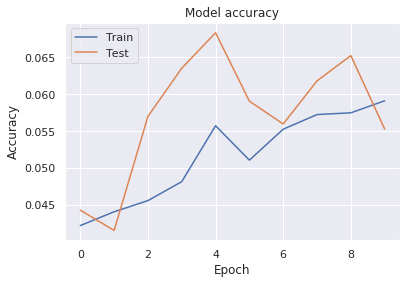

In [37]:
fig, ax = plt.subplots()
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
#fig.savefig('../images/data_augmentation.svg', format='svg', dpi=1200)

In [39]:
a = ['Highway', 'PJFAMaps', 'Map_A7_Einum_Drispenstedt', 'OfflineLocalization', 'Default', 'Rrs2Rrs', 'PoseGraphLocalizer']
if "Highway" in a:
    print a

['Highway', 'PJFAMaps', 'Map_A7_Einum_Drispenstedt', 'OfflineLocalization', 'Default', 'Rrs2Rrs', 'PoseGraphLocalizer']
